<a href="https://www.kaggle.com/code/darvack/transformer-paper?scriptVersionId=129925638" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/transformer/DatasetB.csv
/kaggle/input/transformer/DatasetA.csv


In [2]:
ds_A = pd.read_csv("/kaggle/input/transformer/DatasetA.csv")
ds_B = pd.read_csv("/kaggle/input/transformer/DatasetB.csv")

# Splitting train and test
from sklearn.model_selection import train_test_split
train_set_A, test_set_A = train_test_split(ds_A, test_size = 0.25, random_state = 11)

# Setting the labels
y_train_A = train_set_A['Furan']
y_test_A = test_set_A['Furan']

# Dropping the Furan and Health Index columns
X_train_A = train_set_A.drop(["Furan", "HI"], axis = 1)
X_test_A = test_set_A.drop(["Furan", "HI"], axis = 1)

# For DatasetB
y_B = ds_B['Furan']
X_B = ds_B.drop(["Furan", "HI"], axis = 1)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
X_train_A = X_train_A.drop(set(ds_A.columns) - set(ds_B.columns), axis=1)
X_test_A = X_test_A.drop(set(ds_A.columns) - set(ds_B.columns), axis=1)
X_B = X_B[X_train_A.columns]
X_train_A

,H2,Methane,Acetylene,Ethylene,Ethane,Water,Acid,BDV,IFT
109,12.2,53.50,6.9,127.4,48.0,3,0.043,83.0,20
566,30.2,0.00,0.0,2.6,1.1,3,0.005,84.0,39
410,45.6,18.20,0.0,1.6,1.7,5,0.005,87.0,30
316,19.7,38.50,0.0,2.7,41.6,7,0.005,50.0,32
678,11.0,7.60,0.0,0.3,1.6,3,0.005,61.0,42
...,...,...,...,...,...,...,...,...,...
269,13.7,5.10,0.0,0.4,1.1,1,0.005,94.0,36
337,32.9,3.77,0.0,0.6,2.4,6,0.005,79.0,32
91,22.8,3.30,0.0,4.9,3.0,11,0.140,88.0,16
80,61.2,27.30,0.0,25.6,20.8,9,0.099,70.0,17


In [4]:
# define the bin edges for each class
bins = [-1, 0.1, 1, 100]

# define the labels for each class
labels = [0, 1, 2]

y_train_A = pd.DataFrame(y_train_A)
y_B = pd.DataFrame(y_B)
y_test_A = pd.DataFrame(y_test_A)


# discretize the data into the desired classes
y_train_A['Class'] = pd.cut(y_train_A['Furan'], bins=bins, labels=labels)
y_B['Class'] = pd.cut(y_B['Furan'], bins=bins, labels=labels)
y_test_A['Class'] = pd.cut(y_test_A['Furan'], bins=bins, labels=labels)


y_train_A = np.array(y_train_A.drop("Furan", axis = 1)).ravel()
y_B = np.array(y_B.drop("Furan", axis = 1)).ravel()
y_test_A = np.array(y_test_A.drop("Furan", axis = 1)).ravel()

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
#from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier

#log_clf = LogisticRegression(max_iter=1000)
svm_clf = SVC(probability=True, gamma=0.001)
knn_clf = KNeighborsClassifier(n_neighbors=3)
xgb_clf = XGBClassifier(learning_rate=0.01, n_estimators=300, max_depth=3, subsample=0.7)
mlp_clf = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000)
nb_clf = GaussianNB()
ada_clf = AdaBoostClassifier(n_estimators=50, learning_rate=0.003)

voting_clf = VotingClassifier(
  estimators=[('nn', mlp_clf),
              ('svc', svm_clf),
              ('knn', knn_clf), #('ada', ada_clf),
              ('xgb', xgb_clf), ('nb', nb_clf)],
  voting='hard')
voting_clf.fit(X_train_A, np.array(y_train_A).ravel())

VotingClassifier(estimators=[('nn', MLPClassifier(max_iter=1000)),
                             ('svc', SVC(gamma=0.001, probability=True)),
                             ('knn', KNeighborsClassifier(n_neighbors=3)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=Non...
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.01, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=3,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=300, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=None, ...)),
                             ('nb', GaussianNB())])

In [6]:
from sklearn.metrics import accuracy_score
for clf in (mlp_clf, svm_clf, #ada_clf,
            knn_clf, xgb_clf, nb_clf,
            voting_clf):
    clf.fit(X_train_A, y_train_A)
    y_pred_A = clf.predict(X_test_A)
    y_pred_B = clf.predict(X_B)
    print(clf.__class__.__name__ + " for dataset A:", accuracy_score(y_test_A, y_pred_A))
    print(clf.__class__.__name__ + " for dataset B:", accuracy_score(y_B, y_pred_B))

MLPClassifier for dataset A: 0.8579234972677595
MLPClassifier for dataset B: 0.7981651376146789
SVC for dataset A: 0.8797814207650273
SVC for dataset B: 0.8103975535168195
KNeighborsClassifier for dataset A: 0.8360655737704918
KNeighborsClassifier for dataset B: 0.8042813455657493
XGBClassifier for dataset A: 0.8961748633879781
XGBClassifier for dataset B: 0.764525993883792
GaussianNB for dataset A: 0.8415300546448088
GaussianNB for dataset B: 0.7737003058103975
VotingClassifier for dataset A: 0.912568306010929
VotingClassifier for dataset B: 0.8287461773700305


# Training using all of the data from Dataset A

In [7]:
X_A = ds_A.drop(["Furan", "HI"], axis = 1)
X_A = X_A.drop(set(ds_A.columns) - set(ds_B.columns), axis=1)
y_A = ds_A['Furan']
y_A = np.array(y_A).ravel().astype('int64')
X_A

,H2,Methane,Acetylene,Ethylene,Ethane,Water,Acid,BDV,IFT
0,11.8,0.0,0.0,1.0,1.4,13,0.005,48.0,24
1,329.3,90.9,0.7,26.7,110.3,22,0.096,68.0,17
2,18.5,4.9,0.4,3.4,2.8,8,0.030,70.0,26
3,33.6,3.3,0.3,5.8,4.1,12,0.032,57.0,26
4,16.6,4.4,0.0,2.8,4.4,6,0.036,77.0,24
...,...,...,...,...,...,...,...,...,...
725,71.5,9.7,0.0,0.8,2.5,8,0.005,91.0,31
726,66.0,13.6,0.0,1.3,5.8,9,0.005,94.0,31
727,73.7,10.1,0.0,0.9,4.2,7,0.005,90.0,32
728,52.8,18.3,0.0,1.7,7.7,6,0.005,68.0,32


In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier

lr_clf = LogisticRegression(max_iter=10000)
svm_clf = SVC(probability=True)
knn_clf = KNeighborsClassifier()
xgb_clf = XGBClassifier(learning_rate=0.01, n_estimators=300, max_depth=3, subsample=0.7)
mlp_clf = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000)
nb_clf = GaussianNB()
#ada_clf = AdaBoostClassifier(n_estimators=50, learning_rate=0.003)

voting_clf = VotingClassifier(
  estimators=[#('nn', mlp_clf),
              ('lr', lr_clf),
              #('svc', svm_clf),
              ('knn', knn_clf), #('ada', ada_clf),
              ('xgb', xgb_clf), #('nb', nb_clf)
             ],
  voting='hard')
voting_clf.fit(X_A, y_A)

VotingClassifier(estimators=[('lr', LogisticRegression(max_iter=10000)),
                             ('knn', KNeighborsClassifier()),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.01, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=3,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=300, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=None, ...))])

In [9]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

for clf in (#mlp_clf, svm_clf, #ada_clf,
            knn_clf, xgb_clf, lr_clf, #nb_clf,
            voting_clf):
    label_encoder = LabelEncoder()
    y_A_encoded = label_encoder.fit_transform(y_A)
    clf.fit(X_A, y_A_encoded)
    y_pred_B = clf.predict(X_B)
    print(clf.__class__.__name__ + " for dataset B:", accuracy_score(y_B, y_pred_B))

KNeighborsClassifier for dataset B: 0.8256880733944955
XGBClassifier for dataset B: 0.8318042813455657
LogisticRegression for dataset B: 0.8134556574923547
VotingClassifier for dataset B: 0.8348623853211009


In [10]:
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes, normalize=False, cmap=plt.cm.Blues, title='Confusion matrix'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[253   4   0]
 [ 23  17   0]
 [ 16  14   0]]


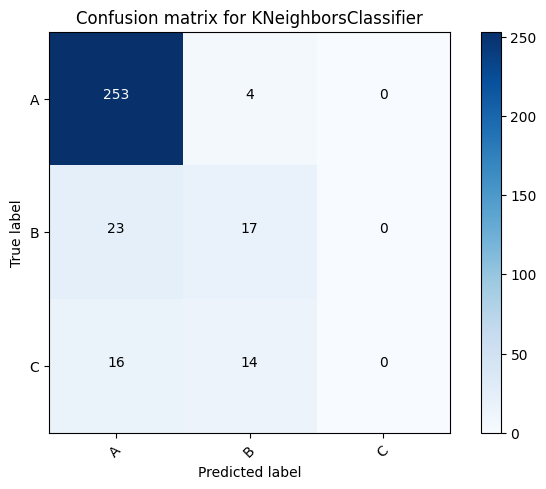

Confusion matrix, without normalization
[[253   4   0   0   0]
 [ 20  18   2   0   0]
 [  6  20   1   2   1]
 [  0   0   0   0   0]
 [  0   0   0   0   0]]


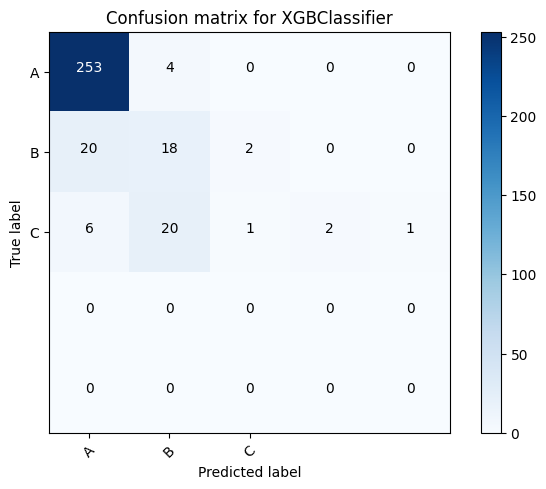

Confusion matrix, without normalization
[[252   2   0   0   1   2   0   0   0]
 [ 24  14   1   1   0   0   0   0   0]
 [ 12   9   0   0   1   5   1   1   1]
 [  0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0]]


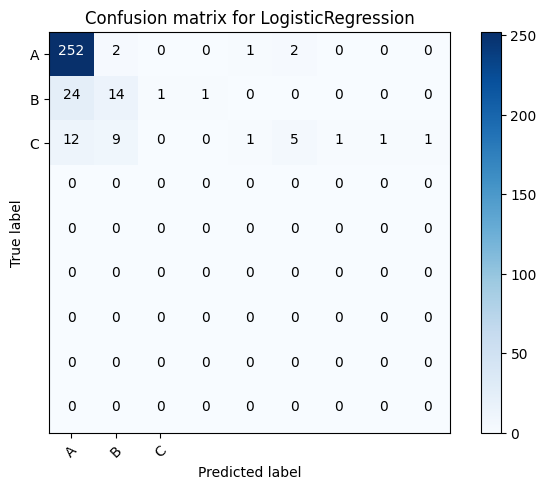

Confusion matrix, without normalization
[[255   2   0   0]
 [ 21  18   1   0]
 [ 14  15   0   1]
 [  0   0   0   0]]


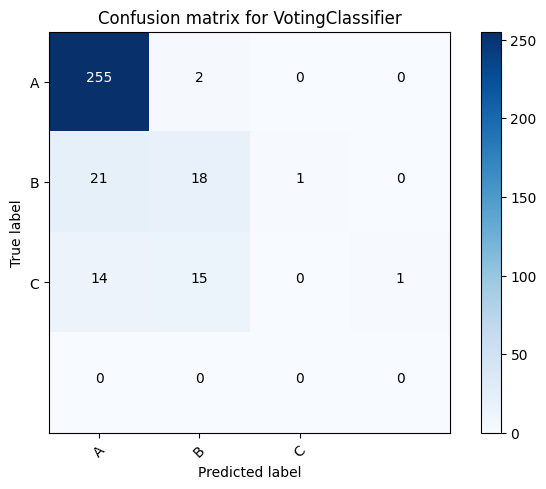

In [11]:
# Example usage
class_names = ['A', 'B', 'C']

for clf in (#mlp_clf, svm_clf, #ada_clf,
            knn_clf, xgb_clf, lr_clf, #nb_clf,
            voting_clf):
    label_encoder = LabelEncoder()
    y_A_encoded = label_encoder.fit_transform(y_A)
    clf.fit(X_A, y_A_encoded)
    y_pred_B = clf.predict(X_B)
    cnf_matrix = confusion_matrix(y_B, y_pred_B)
    np.set_printoptions(precision=2)
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                          title='Confusion matrix for ' + clf.__class__.__name__)
    plt.show()